In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib as mpl

mpl.style.use("seaborn")


/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-04-19 22:10:41: Data set normalized. Mean value std: 0.00870849180058354


In [4]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2,700, 700, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-04-19 22:10:41: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-04-19 22:10:41: Setting up the training in the target graph ...
[-] 2018-04-19 22:10:41: network ...
[-] 2018-04-19 22:10:41: error function ...
[-] 2018-04-19 22:10:41: cost function ...
[-] 2018-04-19 22:10:41: training step
[-] 2018-04-19 22:10:42: Starting network training ...
[ ] 2018-04-19 22:10:42: Val. Cost: 5.797E-02. Error: 5.797E-02. Diff: 1.0E+10
[ ] 2018-04-19 22:10:44: Val. Cost: 4.027E-05. Error: 3.437E-05. Diff: 5.8E-02
[ ] 2018-04-19 22:10:45: Val. Cost: 2.568E-05. Error: 1.988E-05. Diff: 1.4E-05
[ ] 2018-04-19 22:10:47: Val. Cost: 4.679E-05. Error: 4.107E-05. Diff: 2.1E-05
[ ] 2018-04-19 22:10:49: Val. Cost: 4.718E-05. Error: 4.153E-05. Diff: 4.6E-07
[ ] 2018-04-19 22:10:52: Val. Cost: 2.693E-05. Error: 2.136E-05. Diff: 2.0E-05
[ ] 2018-04-19 22:10:53: Val. Cost: 2.931E-05. Error: 2.383E-05. Diff: 2.5E-06
[ ] 2018-04-19 22:10:55: Val. Cost: 1.845E-05. Error: 1.307E-05

$P'= \dfrac{3}{2} PSP - \dfrac{2}{2 \cdot 2}PSPSP $

In [5]:
def mc_wheeny_purification(p,s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return (3 * np.dot(np.dot(p, s), p) - np.dot(np.dot(np.dot(np.dot(p, s), p), s), p)) / 2

def multi_mc_wheeny(p, s, n_max=4):
    for i in range(n_max):
        p = mc_wheeny_purification(p, s)
    return p

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))


In [6]:
#for (s, p) in zip(*dataset.testing):
for (s, p) in zip(S_test, P_test):
    
    #s_norm = s.reshape(1, dim**2)
    s_norm = dataset.input_transformation(s.reshape(1, dim**2))
    
    print("Orip:         {:0.3E}".format(idemp_error(p, s))) 
    print("Orig prurif:  {:0.3E}".format(idemp_error(mc_wheeny_purification(p, s), s)))
    
    with graph_orig.as_default():
        p_nn = network_orig.run(sess_orig, s_norm).reshape(dim, dim)
        
    print("NN:           {:0.3E}".format(idemp_error(p_nn, s)))
    print("NN pruified:  {:0.3E}".format(idemp_error(mc_wheeny_purification(p_nn, s), s)))
    p_nn_multi = multi_mc_wheeny(p_nn, s, n_max=5)
    print("NN multified: {:0.3E}".format(idemp_error(p_nn_multi, s))) 
    print("Value before: {:0.3E}".format(np.mean(np.abs(p.reshape(dim, dim) - p_nn))))
    print("Value multi :  {:0.3E}".format(np.mean(np.abs(p.reshape(dim, dim) - p_nn_multi))))
    print("Is nan: " + str(np.sum(np.isnan(p_nn_multi))))
    print("Is inf: " + str(np.sum(np.isinf(p_nn_multi))))
    print("Is fin: " + str(np.sum(np.isfinite(p_nn_multi))))
    print("--------------------")

Orip:         2.991E-16
Orig prurif:  7.800E-17
NN:           1.689E-03
NN pruified:  2.814E-05
NN multified: 7.060E-17
Value before: 1.065E-03
Value multi :  6.615E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.657E-16
Orig prurif:  8.632E-17
NN:           1.794E-03
NN pruified:  2.254E-05
NN multified: 6.380E-17
Value before: 1.227E-03
Value multi :  8.646E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.750E-16
Orig prurif:  7.025E-17
NN:           2.147E-03
NN pruified:  4.667E-05
NN multified: 6.889E-17
Value before: 1.453E-03
Value multi :  9.495E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.714E-16
Orig prurif:  7.962E-17
NN:           1.183E-03
NN pruified:  1.112E-05
NN multified: 6.613E-17
Value before: 7.670E-04
Value multi :  4.938E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.869E-16
Orig prurif:  9.067E-17
NN:           1.918E-03
NN pruified:  4.323E-05
NN multified: 6.

NN:           1.699E-03
NN pruified:  2.883E-05
NN multified: 6.030E-17
Value before: 1.071E-03
Value multi :  6.173E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.503E-16
Orig prurif:  8.872E-17
NN:           1.883E-03
NN pruified:  3.391E-05
NN multified: 6.808E-17
Value before: 1.283E-03
Value multi :  8.466E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         3.159E-16
Orig prurif:  8.060E-17
NN:           2.525E-03
NN pruified:  7.834E-05
NN multified: 6.812E-17
Value before: 1.435E-03
Value multi :  8.333E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.519E-16
Orig prurif:  8.506E-17
NN:           1.495E-03
NN pruified:  1.686E-05
NN multified: 5.905E-17
Value before: 1.028E-03
Value multi :  7.235E-04
Is nan: 0
Is inf: 0
Is fin: 676
--------------------
Orip:         2.765E-16
Orig prurif:  8.292E-17
NN:           1.372E-03
NN pruified:  1.878E-05
NN multified: 6.653E-17
Value before: 9.249E-04
Value multi :  5

In [7]:
#for (s, p) in zip(*dataset.testing):

error_ori = []
error_sym = []
error_Mc1 = []
error_Mc5 = []

symmetry_ori = []
symmetry_sym = []
symmetry_Mc1 = []
symmetry_Mc5 = []

idemp_ori = []
idemp_sym = []
idemp_Mc1 = []
idemp_Mc5 = []

occ_ori = []
occ_sym = []
occ_Mc1 = []
occ_Mc5 = []

for (s, p) in zip(S_test, P_test):
    
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    
    #s_norm = s.reshape(1, dim**2)
    s_norm = dataset.input_transformation(s.reshape(1, dim**2))
    
    with graph_orig.as_default():
        p_nn = network_orig.run(sess_orig, s_norm).reshape(dim, dim)

    p_sym = (p_nn + p_nn.T)/2
    p_mc1 = mc_wheeny_purification(p_nn, s)
    p_mc5 = multi_mc_wheeny(p_nn, s, n_max=5)
        
    error_ori.append(np.mean(np.abs(p_nn - p)))
    error_sym.append(np.mean(np.abs(p_sym - p)))
    error_Mc1.append(np.mean(np.abs(p_mc1 - p)))
    error_Mc5.append(np.mean(np.abs(p_mc5 - p)))

    symmetry_ori.append(np.mean(np.abs(p_nn - p_nn.T)))
    symmetry_sym.append(np.mean(np.abs(p_sym - p_sym.T)))
    symmetry_Mc1.append(np.mean(np.abs(p_mc1 - p_mc1.T)))
    symmetry_Mc5.append(np.mean(np.abs(p_mc5 - p_mc1.T)))

    idemp_ori.append(idemp_error(p_nn, s))
    idemp_sym.append(idemp_error(p_sym, s))
    idemp_Mc1.append(idemp_error(p_mc1, s))
    idemp_Mc5.append(idemp_error(p_mc5, s))
    
    occ_ori.append(np.abs(np.trace(np.dot(p_nn, s) - 30)))
    occ_sym.append(np.abs(p_sym - p))
    occ_Mc1.append(np.abs(p_mc1 - p))
    occ_Mc5.append(np.abs(p_mc5 - p))


def stats(x):
    return np.mean(x), np.std(x)
    

print("----- NN -----")
print("Abs:  {:0.3E} +- {:0.3E}".format(*stats(error_ori)))
print("Sym:  {:0.3E} +- {:0.3E}".format(*stats(symmetry_ori)))
print("Ide:  {:0.3E} +- {:0.3E}".format(*stats(idemp_ori)))
print("Occ:  {:0.3E} +- {:0.3E}".format(*stats(occ_ori)))
      

print("----- Sym -----")
print("Abs:  {:0.3E} +- {:0.3E}".format(*stats(error_sym)))
print("Sym:  {:0.3E} +- {:0.3E}".format(*stats(symmetry_sym)))
print("Ide:  {:0.3E} +- {:0.3E}".format(*stats(idemp_sym)))
print("Occ:  {:0.3E} +- {:0.3E}".format(*stats(occ_sym)))
      

print("----- McWheeny-1 -----")
print("Abs:  {:0.3E} +- {:0.3E}".format(*stats(error_Mc1)))
print("Sym:  {:0.3E} +- {:0.3E}".format(*stats(symmetry_Mc1)))
print("Ide:  {:0.3E} +- {:0.3E}".format(*stats(idemp_Mc1)))
print("Occ:  {:0.3E} +- {:0.3E}".format(*stats(occ_Mc1)))
      

print("----- McWheeny-5 -----")
print("Abs:  {:0.3E} +- {:0.3E}".format(*stats(error_Mc5)))
print("Sym:  {:0.3E} +- {:0.3E}".format(*stats(symmetry_Mc5)))
print("Ide:  {:0.3E} +- {:0.3E}".format(*stats(idemp_Mc5)))
print("Occ:  {:0.3E} +- {:0.3E}".format(*stats(occ_Mc5)))


----- NN -----
Abs:  1.141E-03 +- 2.388E-04
Sym:  1.140E-03 +- 2.007E-04
Ide:  1.734E-03 +- 4.356E-04
Occ:  7.500E+02 +- 1.217E-01
----- Sym -----
Abs:  9.496E-04 +- 2.222E-04
Sym:  0.000E+00 +- 0.000E+00
Ide:  1.480E-03 +- 4.330E-04
Occ:  9.496E-04 +- 1.144E-03
----- McWheeny-1 -----
Abs:  7.304E-04 +- 1.371E-04
Sym:  8.272E-04 +- 1.491E-04
Ide:  3.250E-05 +- 2.439E-05
Occ:  7.304E-04 +- 6.150E-04
----- McWheeny-5 -----
Abs:  7.297E-04 +- 1.366E-04
Sym:  8.296E-04 +- 1.500E-04
Ide:  6.660E-17 +- 4.401E-18
Occ:  7.297E-04 +- 6.152E-04


In [8]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.analysis import prediction_scatter

dim = 26



iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    

    s_raw = hf.get_ovlp(mol)
    s_norm = dataset.input_transformation(s_raw.reshape(1, dim**2))
    
    with graph_orig.as_default():
        p_nn = network_orig.run(sess_orig, s_norm).reshape(dim, dim).astype('float64')
        
        p_sym = (p_nn + p_nn.T) / 2
        p_mc1 = multi_mc_wheeny(p_nn, s_raw, n_max=1)
        p_mc5 = multi_mc_wheeny(p_nn, s_raw, n_max=5)
        
    
    iterations_molecule = []

    for guess in [p_nn, p_sym, p_mc1,  p_mc5]:
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Calculating: 1/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 2/50


Warn: Ipython shell catchs sys.args


Calculating: 3/50


Warn: Ipython shell catchs sys.args


Calculating: 4/50


Warn: Ipython shell catchs sys.args


Calculating: 5/50


Warn: Ipython shell catchs sys.args


Calculating: 6/50


Warn: Ipython shell catchs sys.args


Calculating: 7/50


Warn: Ipython shell catchs sys.args


Calculating: 8/50


Warn: Ipython shell catchs sys.args


Calculating: 9/50


Warn: Ipython shell catchs sys.args


Calculating: 10/50


Warn: Ipython shell catchs sys.args


Calculating: 11/50


Warn: Ipython shell catchs sys.args


Calculating: 12/50


Warn: Ipython shell catchs sys.args


Calculating: 13/50


Warn: Ipython shell catchs sys.args


Calculating: 14/50


Warn: Ipython shell catchs sys.args


Calculating: 15/50


Warn: Ipython shell catchs sys.args


Calculating: 16/50


Warn: Ipython shell catchs sys.args


Calculating: 17/50


Warn: Ipython shell catchs sys.args


Calculating: 18/50


Warn: Ipython shell catchs sys.args


Calculating: 19/50


Warn: Ipython shell catchs sys.args


Calculating: 20/50


Warn: Ipython shell catchs sys.args


Calculating: 21/50


Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args


Calculating: 23/50


Warn: Ipython shell catchs sys.args


Calculating: 24/50


Warn: Ipython shell catchs sys.args


Calculating: 25/50


Warn: Ipython shell catchs sys.args


Calculating: 26/50


Warn: Ipython shell catchs sys.args


Calculating: 27/50


Warn: Ipython shell catchs sys.args


Calculating: 28/50


Warn: Ipython shell catchs sys.args


Calculating: 29/50


Warn: Ipython shell catchs sys.args


Calculating: 30/50


Warn: Ipython shell catchs sys.args


Calculating: 31/50


Warn: Ipython shell catchs sys.args


Calculating: 32/50


Warn: Ipython shell catchs sys.args


Calculating: 33/50


Warn: Ipython shell catchs sys.args


Calculating: 34/50


Warn: Ipython shell catchs sys.args


Calculating: 35/50


Warn: Ipython shell catchs sys.args


Calculating: 36/50


Warn: Ipython shell catchs sys.args


Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50


Warn: Ipython shell catchs sys.args


Calculating: 39/50


Warn: Ipython shell catchs sys.args


Calculating: 40/50


Warn: Ipython shell catchs sys.args


Calculating: 41/50


Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args


Calculating: 43/50


Warn: Ipython shell catchs sys.args


Calculating: 44/50


Warn: Ipython shell catchs sys.args


Calculating: 45/50


Warn: Ipython shell catchs sys.args


Calculating: 46/50


Warn: Ipython shell catchs sys.args


Calculating: 47/50


Warn: Ipython shell catchs sys.args


Calculating: 48/50


Warn: Ipython shell catchs sys.args


Calculating: 49/50


Warn: Ipython shell catchs sys.args


Calculating: 50/50


In [9]:
print("NN:  {0} +- {1}".format(*stats(iterations[:,0])))
print("Sym: {0} +- {1}".format(*stats(iterations[:,1])))
print("Mc1: {0} +- {1}".format(*stats(iterations[:,2])))
print("Mc5: {0} +- {1}".format(*stats(iterations[:,3])))

NN:  12.16 +- 2.138784701647176
Sym: 12.2 +- 2.0880613017821097
Mc1: 8.28 +- 1.2496399481450646
Mc5: 8.34 +- 1.1766052864066183


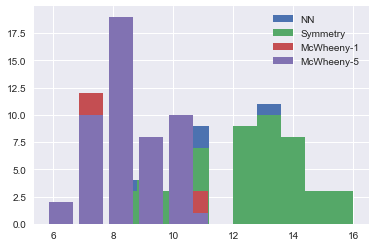

In [10]:
labels = ["NN", "Symmetry", "McWheeny-1", "McWheeny-5"]

bins = 20 # todo hier kann man auch ein array angeben
for i, label in enumerate(labels):
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=label)
    
plt.legend()
plt.show()